# Build a GUI to implement a decision tree

In [27]:
import numpy as np
import pandas as pd
from tkinter import *
import tkinter.font as font
import tkinter.filedialog
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from PIL import Image
import os

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1 

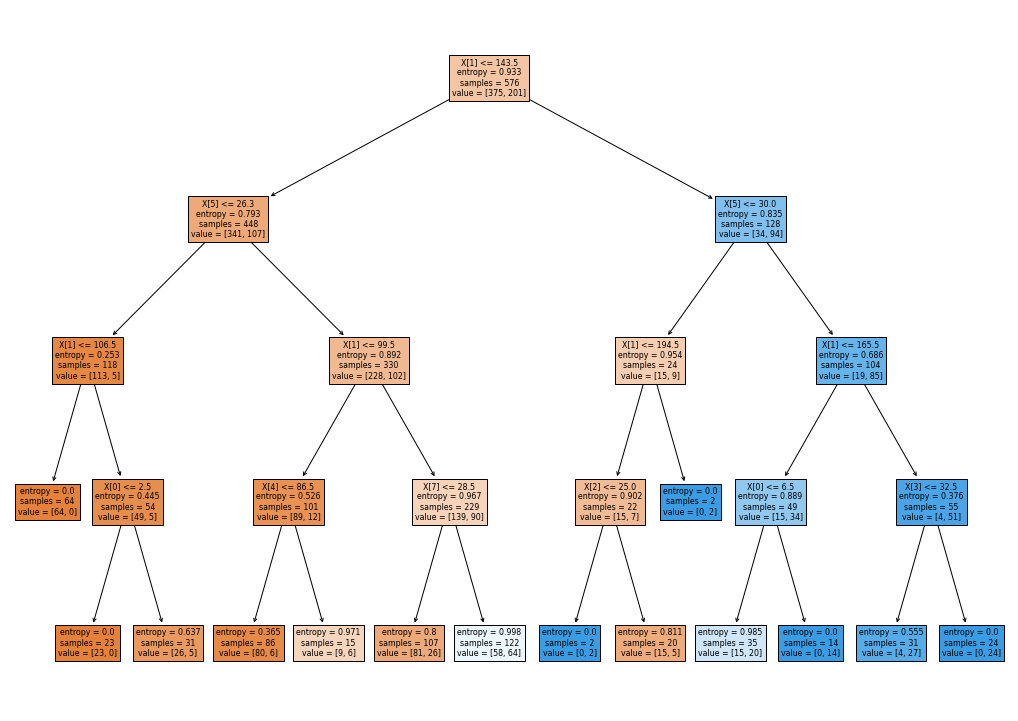

In [28]:
def upload_file():
    try:
        global df
        global cols
        filepath = tkinter.filedialog.askopenfilename()
        file = open(filepath, 'r')
        t_upload.delete(1.0, END)
        t_train.delete(1.0,END)
        t_upload.insert(END, filepath)
        df = pd.read_csv(filepath)
        
        # in case dataset does not have any rows for column name 
        if checkVar.get() == 0:
            tmp_cols = ["col_"+str(i) for i in range(df.shape[1])]
            df = pd.read_csv(filepath, names = tmp_cols)
    
        cols = list(df.columns)
        file.close()
        
        # Preprocessing Frame gets updated while uploading dataset
        global f1
        global Lb
        f1 = Frame(window)
        Lb = Listbox (f1,height=10, selectmode= MULTIPLE)
        for i in range(len(cols)):
            Lb.insert(i, str(cols[i]))
        scrollbar = Scrollbar(f1)
        Lb.pack(side = LEFT, fill = BOTH)
        Lb.config(yscrollcommand = scrollbar.set) 
        scrollbar.config(command = Lb.yview)
        scrollbar.pack(side = RIGHT, fill = BOTH)
        f1.place(x=600,y=70)
        
        #debug printing on console
        print(df.head())
        
    except FileNotFoundError:
        return
    
        
def train(attribute_selection_method):
    global df
    global model
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_widget.get(), random_state=random_state_widget.get())
    
    model = DecisionTreeClassifier(criterion=attribute_selection_method, max_depth=4)
    model = model.fit(X_train, y_train)
   
    # predict from the model
    y_pred = model.predict(X_test)
    global accuracy
    global report
    global matrix
    accuracy = accuracy_score(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    

def error_popup(message):
    error_window = Toplevel()
    error_window.title("ERROR")
    error_window.geometry("360x120")
    error_window.configure(bg='#F5B7B1')
    e = Label(error_window, text = message, fg='red',bg='#F5B7B1',font= myFont)
    symbol = Label(error_window, text = "X", fg='red',bg='#F5B7B1', font=x_large)
    e.pack()
    symbol.pack()
    error_window.mainloop()

    
def train_model(attribute_selection_method):
    if len(t_upload.get(1.0, END)) == 1:
        t_train.delete(1.0, END)
        t_train.insert(END, "Enter dataset first !")
        #show popup window in case user click on train button without uploading any file
        error_popup("ERROR! Upload Data FIrst")
        return 
    
    # calling machine learning part to train the model
    train(attribute_selection_method)
    
    # save the plot tree as an image file
    fig = plt.figure(figsize=(18,13))
    tmp = tree.plot_tree(model, filled=True)
    fig.savefig("decision_tree.png")
    t_train.delete(1.0, END)
    t_train.insert(END, "Training Done!")
    
    # show pop up when Training is Done
    success_window = Toplevel()
    success_window.title("DONE")
    success_window.geometry("300x150")
    success_window.configure(bg='#d5f3f5')
    s = Label(success_window, text = " ~ TRAINING DONE ~", fg='blue',bg='#d5f3f5', font=myFont)
    sign = Label(success_window, text =u"\u2713", fg='blue',bg='#d5f3f5', font=x_large)
    s.pack()
    sign.pack()
    success_window.mainloop()
    

    
def plot_tree():
    #if training is done, plot the tree in a new window
    if t_train.get("1.0", 'end-1c') == "Training Done!":
        plot_window = Toplevel()
        plot_window.title("Decision Tree")
        plot_window.geometry("1200x1200")
    
        photo = PhotoImage(file="decision_tree.png")

        w = Label(plot_window,image=photo)
        w.configure(bg='#d9ffcc')
        w.pack()
        plot_window.mainloop()
    else:
        #error popup, in case user want to plot without train the model
        error_popup("ERROR! Upload Data and Train FIrst")
    
    
def show_result(attribute_selection_method):
    # error popup in case if no dataset uploaded or training not done yet
    if len(t_upload.get(1.0, END)) == 1 or t_train.get(1.0, 'end-1c') != "Training Done!":
        error_popup("ERROR! Upload Data and Train FIrst")
        return
    result_window = Toplevel()
    result_window.title("Classification Report")
    result_window.geometry("550x450")
    result_window.configure(bg='#d9ffcc')
    result_label = Label(result_window, text = f"Attribute Selection Method = {attribute_selection_method}\n\nAccuracy = {accuracy}\n\nconfusion matrix\n{matrix}\n\n{report}" ,bg='#CCCCFF', font= small_font)
    result_label.pack()
    result_window.mainloop()
    

def compare():
    result_dict = {}
    if len(t_upload.get(1.0, END)) == 1:
        error_popup("ERROR! Upload Data FIrst")
    else:    
        for method in options:
            train(method)  
            result_dict[method] = f"Attribute Selection Method = {method}\n\nAccuracy = {accuracy}\n\nconfusion matrix\n{matrix}\n\n{report}"
        
        compare_window = Toplevel()
        compare_window.title("COMPARE")
        compare_window.geometry("900x500")
        compare_window.configure(bg='#d9ffcc')
        xpos = 10
        ypos = 10
        for method, this_report in result_dict.items():
            e = Label(compare_window, text = this_report ,bg='#d9ffcc', font=small_font)
            e.place(x=xpos, y=ypos)
            xpos += 430
        compare_window.mainloop()
    
def getval_and_encode():
    try:
        global df
        global cols
        global Lb
        cols_need_encode = list(Lb.curselection())
        cols_need_encode = [cols[i] for i in cols_need_encode]

        for this_col in cols_need_encode:
            label_encoder = preprocessing.LabelEncoder()
            df[f"{this_col}"]= label_encoder.fit_transform(df[f"{this_col}"])

        print(df.head())
        # Encoding Done pop_up
        success_window = Toplevel()
        success_window.title("ENCODING DONE")
        success_window.geometry("300x150")
        success_window.configure(bg='#D5F5E3')
        e = Label(success_window, text = " ~ ENCODING DONE ~", fg='green',bg='#D5F5E3', font=myFont)
        sign = Label(success_window, text =u"\u2713", fg='green',bg='#D5F5E3', font=x_large)
        e.pack()
        sign.pack()
        success_window.mainloop()
    except TclError:
        error_popup("ERROR! Upload Data FIrst")
    
    
                         ###################### Main window starts ##########################
window = Tk()
window.title("Home Window")
window.geometry("800x410")
window.configure(bg='#e1ffcc')

small_font = font.Font(size=13)
myFont = font.Font(size=15)
x_large = font.Font(size=40)

# functionality of exit button
def exit():
    if os.path.exists("decision_tree.png"):
        os.remove("decision_tree.png")
    window.destroy()

# scroll bar for random state value
random_state_widget = Scale(window, from_=0, to=100,orient=HORIZONTAL)            
random_state_widget.set(0)
random_state_widget.place(x=370, y=98)
random_state_label = Label(window, text = "Random State:", fg='black',bg='#ccdfff', font=small_font)
random_state_label.place(x=255, y=110)

# scroll bar for test split value
test_split_widget = Scale(window, from_=0.0, to=1.0,resolution=0.05,orient=HORIZONTAL)            
test_split_widget.set(0.2)
test_split_widget.place(x=135, y=98)
test_split_label = Label(window, text = "Test_size :", fg='black',bg='#ccdfff', font=small_font)
test_split_label.place(x=47, y=110)



# check box for columns is there or not
checkVar = IntVar(value=1)
c = Checkbutton(window, text = "HasColRows?", variable = checkVar, onvalue = 1, offvalue = 0, height=1,width = 11)
c.place(x=12, y=19)


attribute_method_label = Label(window, text = "Attribute\nselection\nMethod", fg='black',bg='#ccdfff', font=small_font)
attribute_method_label.place(x=485, y=90)
    
# option menu for attribute selection method
options = ["entropy", "gini"]
clicked = StringVar()
clicked.set(options[0])
drop = OptionMenu(window, clicked, *options)
drop.place(x=472, y=154)
drop.config(padx=19,pady=8,bg='#29b9a6',fg='white')
                
    
# buttons declaration
upload_button = Button(text="Upload File",padx=20, pady=10,bg='#29b9a6', fg='white', command=upload_file)
train_model_button = Button(text="Train Model",padx=17,pady=10,bg='#29b9a6',fg='white', command=lambda: train_model(clicked.get()))
plot_tree_button = Button(text="Plot Tree",padx=47,pady=10,bg='#29b9a6',fg='white', command=plot_tree)
compare_button = Button(text="Train And\nCompare Result", padx=30,pady=3,bg='#29b9a6',fg='white', command=compare)
show_result_button = Button(text="Show Classification Result",padx=40,pady=10,bg='#29b9a6',fg='white', command=lambda: show_result(clicked.get()))
exit_button = Button(text="EXIT", padx=37,pady=10,bg='#ff4d4d',fg='white', command=exit)



# buttons placing
upload_button.place(x=10, y=45)
train_model_button.place(x=20, y=150)
plot_tree_button.place(x=10, y = 250)
show_result_button.place(x=175, y=250)
compare_button.place(x=415, y=250)
exit_button.place(x=260,y=320)


#text boxes declare and places
t_upload = Text(window, width=54,height=2)
t_train = Text(window, width=40,height=2)

t_upload.place(x=135 , y=46)
t_train.place(x=135, y=154)

# Preprocessing labels and buttons
preprocess_label = Label(window, text = "Select Columns\nFor Label Encoding", fg='black',bg='#ccefff', font=small_font)
preprocess_label.place(x=600, y=25)
encode_button = Button(text="ENCODE", padx=40,pady=10,bg='#4dff56',fg='black', command=getval_and_encode)
encode_button.place(x=600,y=240)

window.mainloop()